import stuff

In [2]:
from dotenv import load_dotenv
import sys
sys.path.append("../../")
from shared.models import MiniPileDataset
from shared.contra import BottleneckT5Autoencoder
from shared.interp import count_non_zero_feature_activations, plot_feature_activation_histogram
from shared.features import Feature, FeatureSample
import os
import json
import torch

# Enable automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2


# Load environment variables from .env file
load_dotenv()

# Access the OpenAI API key from the environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")


/home/ubuntu/steering-collab/LLMonade/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


In [5]:
folder = "../training_sae/saes/spam_messages_4_20241106_111701"

In [7]:
# Load the model from the pickle file
import pickle 
import sys
import os

from shared.sparse_autoencoder import SparseAutoencoder, SparseAutoencoderConfig
import json

# load the dataset
sentences_file = "../data_preparation/chunking/chunked_datasets/spam_messages_train_20241106_095507.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_messages_4_20241106_110416/embeddings.npy"
mini_pile_dataset = MiniPileDataset(sentences_file, embeddings_file)

# Load the configuration from the JSON file
config_path = os.path.join(folder, 'config.json')
with open(config_path, "r") as config_file:
    config = json.load(config_file)

# Load the pre-trained model from the pickle file
sae_config = SparseAutoencoderConfig(d_model=config["dimensions"], d_sparse=8 * config["dimensions"], sparsity_alpha=config["sparsity_alpha"])
model = SparseAutoencoder(sae_config)

with open(os.path.join(folder, 'sae.pkl'), "rb") as f:
    model_state_dict = pickle.load(f)
    model.load_state_dict(model_state_dict)

/home/ubuntu/steering-collab/LLMonade/.venv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

In [8]:
# Load the log feature densities from the JSON file
log_feature_densities_path = os.path.join(folder, "log_feature_densities.json")
with open(log_feature_densities_path, "r") as json_file:
    log_feature_densities = json.load(json_file)

print("Log feature densities loaded successfully.")


Log feature densities loaded successfully.


interpret the feature activations

len(filtered_feature_activations) 2815


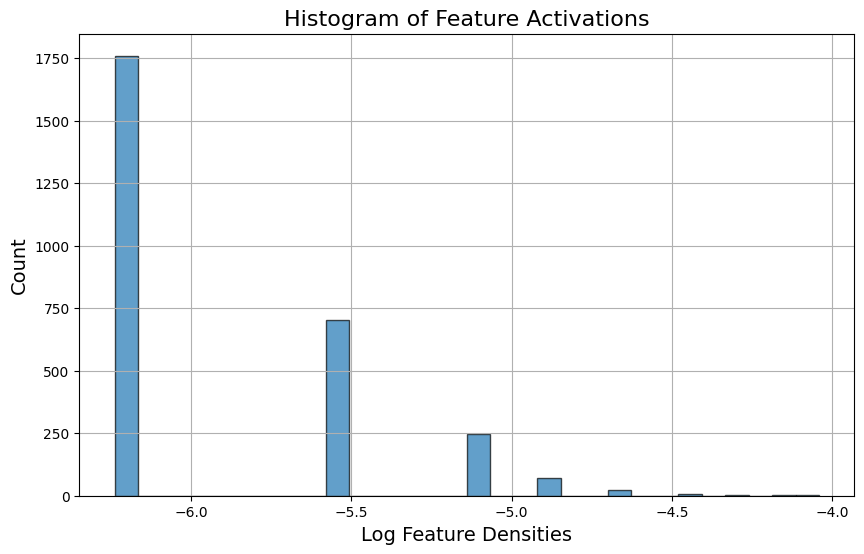

In [9]:
training_step = len(log_feature_densities) - 5
feature_activations = log_feature_densities[training_step]

# Filter out -inf values
filtered_feature_activations = [fa for fa in feature_activations if fa != -float('inf')]
print("len(filtered_feature_activations)", len(filtered_feature_activations))

import matplotlib.pyplot as plt

# Plotting the histogram of feature activations
plt.figure(figsize=(10, 6))
plt.hist(filtered_feature_activations, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Log Feature Densities", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Histogram of Feature Activations", fontsize=16)
plt.grid(True)
plt.show()


In [6]:
len(mini_pile_dataset)

47392

In [10]:
count_non_zero_feature_activations(model, mini_pile_dataset, 1000)

Average Non-Zero Elements for first 1000 samples: 19.152000427246094
Average Percentage of Non-Zero Elements: 0.31%


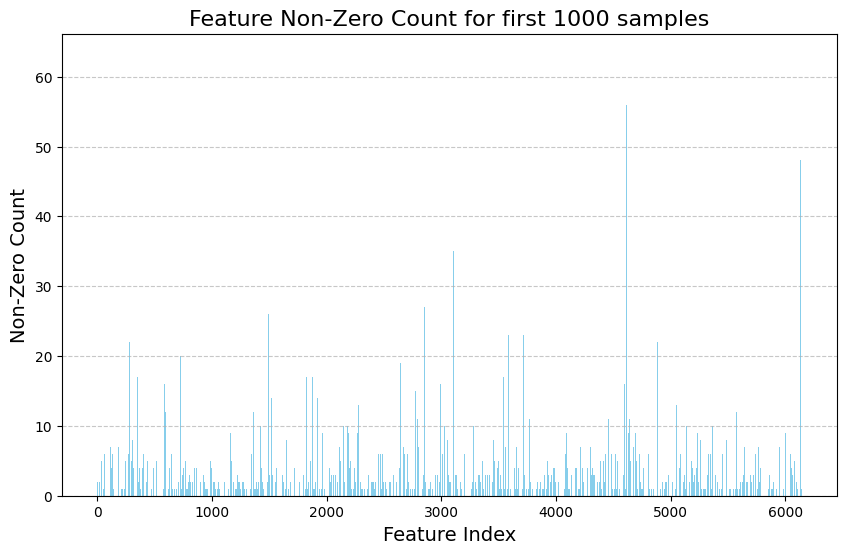

In [11]:
plot_feature_activation_histogram(model, mini_pile_dataset)

automated interp pipeline: analysis

In [3]:
import os
import json

features_folder = "../feature_extraction/features/20241106_112031"
features = []
filtered_out_count = 0

for filename in os.listdir(features_folder):
    if filename.startswith("feature_") and filename.endswith(".json"):
        with open(os.path.join(features_folder, filename), "r") as json_file:
            feature_data = json.load(json_file)
            feature = Feature(**feature_data)
            if len(feature.high_act_samples) >= 10:
                features.append(feature)
            else:
                filtered_out_count += 1

features.sort(key=lambda x: x.confidence, reverse=True)

print(f"Number of filtered out samples: {filtered_out_count}")

Number of filtered out samples: 0


In [13]:
for feature in features[:200]:
    print(f"Index: {feature.index}, Label: {feature.label}, Confidence: {feature.confidence}")

Index: 23, Label: Repetitive phrase structure, Confidence: 100.0
Index: 56, Label: Enthusiastic and excited tone, Confidence: 90.0
Index: 194, Label: Expressions of gratitude and encouragement, Confidence: 79.0
Index: 4, Label: Focus on resource exploration activities, Confidence: 71.0
Index: 66, Label: Expressions of gratitude and positivity, Confidence: 70.0
Index: 125, Label: Legal and regulatory references, Confidence: 68.0
Index: 65, Label: Promotional language and offers, Confidence: 67.0
Index: 162, Label: Promotional and financial benefits, Confidence: 62.0
Index: 115, Label: Promotional and marketing content, Confidence: 62.0
Index: 109, Label: Promotional and inviting language, Confidence: 60.0
Index: 152, Label: Apology and error notifications present, Confidence: 59.0
Index: 145, Label: Personal and emotional narratives, Confidence: 57.0
Index: 85, Label: Expressions of positivity and encouragement, Confidence: 56.0
Index: 77, Label: Focus on investment and operations, Conf

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
autoencoder = BottleneckT5Autoencoder(model_path='thesephist/contra-bottleneck-t5-base-wikipedia', device=device)

In [22]:
# Ensure the model is on the correct device
model = model.to(device)

t = "The theatre has undergone several updates before its move from the Dramacor by British Film Commission"
feature_index = 7

embedding = autoencoder.embed(t)
# Move the embedding to the same device as the model
embedding = embedding.to(device)

feature_activations = model.forward(embedding)[1]

feature_activations[feature_index]

tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)

In [23]:
feature_activations[feature_index] = 20

reconstruction = autoencoder.generate_from_latent(model.decode(feature_activations))

print(reconstruction)

from the previous round (for the match between the teams), and
